# Dimensionality reduction

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder) and uses them as input for a 
dimensionality reduction algorithm, to generate projectsion of the embeddings

In [1]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan

In [2]:
check_memory_usage = True

In [3]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 19
GPU | Used mem: 24
GPU | Memory Usage: [███████████████-----] 79%


In [4]:
#Get W&B API
api = wandb.Api()

## Config parameters

Put here everything that could be needed if this notebook

TODO: Change to config.py & tml version when fixed

In [5]:
## Buscando una combinación buena
cpu_flag = False

if cpu_flag:
    n_neighbors = 15
    min_dist = 0.1
else: 
    n_neighbors = 15 #200
    min_dist = 0.1 #0.0001
    

In [6]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'mi-santamaria/deepvats/mvp-SWV:latest', # Name:version of the encoder artifact
    n_neighbors = n_neighbors, #15, #UMAP
    min_dist = min_dist, #0.1, #UMAP,
    random_state = int(1234), # UMAP
    metric = 'euclidean',
    cpu = cpu_flag
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

## Run

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="04_dimensionality_reduction"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [8]:
run_dr = wandb.init(
    entity=config.wandb_entity,
    project=config.wandb_project if config.use_wandb else 'work-nbs', 
    group=config.wandb_group,
    allow_val_change=True, 
    job_type='dimensionality_reduction', 
    mode='online' if config.use_wandb else 'disabled',
    anonymous = 'never' if config.use_wandb else 'must',
    config=config,
    resume = 'allow',
    name = runname
    #resume=False
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/04_dimensionality_reduction.ipynb.


In [9]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'r': 0.71,
 'w': 30,
 'MVP': {'r': 0.71,
  'lm': 3.0,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '194579535599985797',
  'type': "<class 'fastai.learner.Learner'>"},
 'alias': 'Monash-Australian_electricity_demand',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [15, 30],
 'stride': 15,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7f829251fe50>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELo

In [11]:
enc_artifact.name

'mvp-SWV:v14'

In [12]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [13]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
    print("enc_artifact_valid:", enc_artifact_valid.name)
print("enc_artifact_train: ", enc_artifact_train.name)

enc_artifact_train:  Monash-Australian_electricity_demand:v7


Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_train
dr_artifact.name

'Monash-Australian_electricity_demand:v7'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [15]:
df = dr_artifact.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,penguin_sample
1970-01-01 00:00:00,0.253906
1970-01-01 10:00:00,0.259033
1970-01-01 20:00:00,0.269287
1970-01-02 06:00:00,0.271240
1970-01-02 16:00:00,0.265137


In [16]:
type(df)

pandas.core.frame.DataFrame

In [17]:
print(df.shape)
print(np.round(df.shape[0]/ 1e6, 1))
print(np.round(df.shape[0]/ 1e3, 1))

(109842, 1)
0.1
109.8


In [18]:
show_time_series_flag = False
if show_time_series_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [19]:
import time

In [20]:
w = enc_logger.config['w']
print(w)

30


In [21]:
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


In [22]:
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1725375119.2194593  | end  1725375119.2200575 total (secs):  0.0005981922149658203
(109812, 1, 30)


In [23]:
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


### Getting the embeddings (activations) from the encoder

In [24]:
stride = enc_logger.config['stride']
batch_size = enc_logger.config['batch_size']

In [25]:
print(stride)
print(batch_size)

15
512


In [26]:
print(enc_input.shape)
print(enc_artifact.name)

(109812, 1, 30)
mvp-SWV:v14


In [27]:
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


In [28]:
i = 0
for a in range (enc_input.shape[0]):
    for b in range (enc_input.shape[1]):
        for c in range (enc_input.shape[2]):
            if enc_input[a,b,c] != 0: 
                print(a,b,c, enc_input[a,b,c])
                i+=1
                if i == 10: break
        if i == 10: break
    if i == 10: break

0 0 0 0.253906
0 0 1 0.259033
0 0 2 0.269287
0 0 3 0.27124
0 0 4 0.265137
0 0 5 0.26001
0 0 6 0.246826
0 0 7 0.239746
0 0 8 0.231445
0 0 9 0.230469


In [29]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [30]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride = stride,
    batch_size = batch_size,
    cpu=config.cpu,
    to_numpy = True, 
    verbose = 0,
    time_flag = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 1.7507495880126953 seconds
GE start |  1725375119.6195078  | end  1725375121.3710127 total (secs):  1.751504898071289


In [31]:
beep(0.05)

In [32]:
embs.shape

(7321, 128)

In [33]:
embs[0,0:20]

array([2.3463004e+00, 6.9048226e-01, 1.0934271e+00, 1.5532656e-01,
       0.0000000e+00, 1.3984704e+00, 5.9068793e-01, 2.1384809e+00,
       6.1656634e-04, 6.0700881e-01, 0.0000000e+00, 8.8815993e-01,
       7.4281400e-01, 0.0000000e+00, 1.0404567e-03, 2.4985318e+00,
       2.5315902e+00, 9.7356397e-01, 0.0000000e+00, 1.6171077e+00],
      dtype=float32)

In [34]:
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end (next cell) ", t_end, "total (secs): ", t)

GE start |  1725375119.6195078  | end (next cell)  1725375122.4426646 total (secs):  2.8231568336486816


In [35]:
if check_memory_usage: gpu_memory_status(gpu_device)

GPU | Used mem: 21
GPU | Used mem: 24
GPU | Memory Usage: [█████████████████---] 88%


In [36]:
run_dr.finish()

In [37]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)

### Dimensions check

In [38]:
print(embs.shape)
print(enc_input.shape)

(7321, 128)
(109812, 1, 30)


In [39]:
embs[0]

array([2.34630036e+00, 6.90482259e-01, 1.09342706e+00, 1.55326560e-01,
       0.00000000e+00, 1.39847040e+00, 5.90687931e-01, 2.13848090e+00,
       6.16566336e-04, 6.07008815e-01, 0.00000000e+00, 8.88159931e-01,
       7.42814004e-01, 0.00000000e+00, 1.04045670e-03, 2.49853182e+00,
       2.53159022e+00, 9.73563969e-01, 0.00000000e+00, 1.61710775e+00,
       1.68987834e+00, 5.84347904e-01, 2.19688010e+00, 0.00000000e+00,
       2.93054318e+00, 2.49962306e+00, 5.51102638e-01, 1.86034050e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.58317006e+00, 1.59617305e+00, 3.41661572e-01, 1.07160163e+00,
       1.34080667e-02, 0.00000000e+00, 1.31295145e+00, 1.38264745e-01,
       0.00000000e+00, 0.00000000e+00, 1.43624842e-03, 8.86967301e-01,
       2.02976537e+00, 3.50783277e+00, 2.07206798e+00, 0.00000000e+00,
       1.92988336e+00, 1.69085646e+00, 2.90071011e+00, 1.80355668e+00,
       6.87419593e-01, 2.13578320e+00, 1.83550692e+00, 6.46750212e-01,
      

In [40]:
#Dimensions check
num_inputs = np.ceil(enc_input.shape[0]/stride)
num_embs = embs.shape[0]
test_eq(num_inputs, num_embs )
print(num_inputs, num_embs)

7321.0 7321


Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [41]:
if cpu_flag:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        'output_metric': 'euclidean',
        'verbose': 4,
        'n_epochs': 200
    }
else:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 6,
        'n_epochs': 200
    }






check_reducer = True
if check_reducer:
    import umap
    import cuml
    print("-- umap.UMAP --", cpu_flag)
    reducer1 = umap.UMAP(force_approximation_algorithm = True, **umap_params)
    print("-- cuml.UMAP --", cpu_flag)
    reducer2 = cuml.UMAP(**umap_params)
    print("------- reducer1 --------")
    print(reducer1)
    params1=AttrDict(reducer1.get_params())
    print("------- reducer2 --------")
    print(reducer2)
    params2=AttrDict(reducer2.get_params())
    print("------- reducer2 --------")
    diff_attrdict(dict_original=params2, dict_modified=params1, both=True)
    beep(0.10)

#if not cpu_flag:
    #umap_params['force_approximation_algorithm'] = True # Este no parece ser el influencer
    #umap_params['angular_rp_forest'] = True #No es el influencer

#if params2['random_state'] != 1234:
 #   raise Exception("Wrong random_state params")

-- umap.UMAP -- False
-- cuml.UMAP -- False
------- reducer1 --------
UMAP(a=1.5769434601962196, b=0.8950608779914887, force_approximation_algorithm=True, n_epochs=200, random_state=1234, target_metric='euclidean', target_n_neighbors=15, verbose=6)
------- reducer2 --------
UMAP()
------- reducer2 --------
callback is missing in modified dict | 0 
output_metric_kwds is missing in original dict | None 
learning_rate: 1.0
target_weight: 0.5
n_components: 2
precomputed_knn: None -> (None, None, None)
init: spectral
hash_input is missing in modified dict | 0 
a: 1.5769434601962196
n_neighbors: 15
local_connectivity: 1.0
negative_sample_rate: 5
force_approximation_algorithm is missing in original dict | True 
metric_kwds: None
set_op_mix_ratio: 1.0
n_jobs is missing in original dict | -1 
handle is missing in modified dict | 0 
disconnection_distance is missing in original dict | None 
target_metric_kwds is missing in original dict | None 
random_state: 1234
metric: euclidean
dens_lambda is

In [42]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(7321, 128)

In [43]:
umap_params_cpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        #'a': 1.5769434601962196,
        #'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        #'output_metric': 'euclidean',
        'verbose': 4,
        #'n_epochs': 200
    }
umap_params_gpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 4, #6, #CUML_LEVEL_TRACE
        'n_epochs': 200*3*2,
        'init': 'random',
        'hash_input': True
    }


if cpu_flag:
    umap_params = umap_params_cpu
else:
    umap_params = umap_params_gpu

umap_params


{'n_neighbors': 15,
 'min_dist': 0.1,
 'random_state': 1234,
 'metric': 'euclidean',
 'a': 1.5769434601962196,
 'b': 0.8950608779914887,
 'target_metric': 'euclidean',
 'target_n_neighbors': 15,
 'verbose': 4,
 'n_epochs': 1200,
 'init': 'random',
 'hash_input': True}


<div style="border:2px solid red; padding:10px;">
    <strong>⚠️ Low quality embeddings graphics when using GPU </strong> 
    
    If getting  low quality embedding graphics, use 'True' for using CPU instead of CPU. There is a known issue in CUML library related to laplacian eigenmaps that affects to the embeddings calculus.
> | Check [GPU VS CPU error in cuml](https://github.com/rapidsai/cuml/issues/5474)
</div>
 **Low quality embeddings graphics***
 
 


In [45]:
prjs_umap = get_UMAP_prjs(
    input_data = embs_no_nan, 
    cpu = cpu_flag, #config_dr.cpu, 
    #target_weight=1,
    **umap_params
)
prjs_umap.shape

--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234, 'metric': 'euclidean', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_metric': 'euclidean', 'target_n_neighbors': 15, 'n_epochs': 1200, 'init': 'random', 'hash_input': True}
cea88ab83309324028668aee06e1c455
GPU | Used mem: 20
GPU | Used mem: 24
GPU | Memory Usage: [████████████████----] 83%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7f87c9f02d60>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': 1200, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'random', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': 15, 'target_weight': 0.5, 'target_metric': 'euclidean', 'hash_input': True, 'random_state': 1234, 'callback': None

(7321, 2)

In [46]:
beep(0.15)
beep(0.15)
beep(0.15)


In [47]:
prjs_umap[0:10] # En R head(res[1,],10)

array([[-2.7023468,  1.6770716],
       [-1.9398699,  2.2672539],
       [-0.7746   ,  2.4246683],
       [-1.9731703,  2.3218584],
       [-2.2783318,  2.0961695],
       [-1.9374981,  2.3322887],
       [-2.6535645,  1.6940379],
       [-2.988264 ,  1.3221245],
       [-3.019288 ,  1.2762461],
       [-2.593172 ,  1.783514 ]], dtype=float32)

In [48]:
#prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
#prjs.shape

Save the projections as an artifact

In [49]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [50]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [51]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 10, #100,
    'min_samples' : 10,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [52]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(51, 15),
 (72, 31),
 (64, 20),
 (-1, 1932),
 (50, 21),
 (57, 14),
 (60, 29),
 (65, 28),
 (66, 13),
 (54, 30),
 (58, 36),
 (62, 69),
 (55, 29),
 (112, 136),
 (120, 20),
 (63, 27),
 (73, 36),
 (59, 40),
 (123, 188),
 (125, 24),
 (126, 22),
 (90, 39),
 (21, 34),
 (24, 54),
 (95, 153),
 (61, 15),
 (28, 42),
 (31, 11),
 (25, 19),
 (32, 35),
 (3, 160),
 (0, 213),
 (5, 93),
 (10, 38),
 (118, 188),
 (80, 10),
 (117, 36),
 (129, 23),
 (114, 66),
 (78, 26),
 (1, 89),
 (11, 54),
 (6, 46),
 (97, 31),
 (88, 34),
 (96, 45),
 (49, 347),
 (18, 23),
 (17, 13),
 (12, 36),
 (40, 35),
 (22, 26),
 (8, 42),
 (33, 11),
 (7, 38),
 (4, 12),
 (9, 40),
 (43, 18),
 (110, 43),
 (82, 25),
 (128, 31),
 (101, 25),
 (38, 190),
 (53, 34),
 (42, 87),
 (98, 13),
 (45, 21),
 (105, 23),
 (77, 56),
 (44, 15),
 (47, 28),
 (116, 26),
 (26, 10),
 (39, 101),
 (2, 84),
 (108, 31),
 (71, 32),
 (115, 90),
 (86, 17),
 (48, 59),
 (104, 12),
 (70, 15),
 (74, 37),
 (106, 31),
 (102, 31),
 (121, 26),
 (94, 19),
 (69, 21),
 (127, 21),

#### Ensure good quality embeddings
 

In [53]:
score = cluster_score(prjs_umap, clusters_labels, True)

Silhouette_score: 0.14818667


In [54]:
if score <= 0:
    print("Clusters are not good enough. Repeat embeddings with CPU")
    prjs_umap = get_UMAP_prjs(input_data = embs_no_nan, cpu = True, verbose = 0, **umap_params_cpu)
    prjs_umap.shape    
    # Create clusters using HDBSCAN
    clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
    clusters_labels = clusters.labels_
    list(Counter(clusters_labels).items())

cluster_score(prjs_umap, clusters_labels, True)

Silhouette_score: 0.14818667


0.14818667

In [55]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs_umap.shape[0])

In [56]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '-1718661788372712620', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='-1718661788372712620', digest='nKAzfB+sIuIuFfI63JrFfw==', ref='file:///home/macu/data/wandb_artifacts/-1718661788372712620', birth_artifact_id=None, size=58719, extra={}, local_path=None)]))

In [57]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [58]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [59]:
#| export
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[ 51  72  64  -1  50  57  60  65  66  54  58  62  55 112 120  63  73  59
 123 125 126  90  21  24  95  61  28  31  25  32   3   0   5  10 118  80
 117 129 114  78   1  11   6  97  88  96  49  18  17  12  40  22   8  33
   7   4   9  43 110  82 128 101  38  53  42  98  45 105  77  44  47 116
  26  39   2 108  71 115  86  48 104  70  74 106 102 121  94  69 127 122
  84  76 103  87 111  75  85 130 124 119 100  92  19  83  81  16  27  13
  34  20  37  29  30  36  35  23  56  79  89  14 113 109  99  41  15  91
  93 107  67  68  46  52]


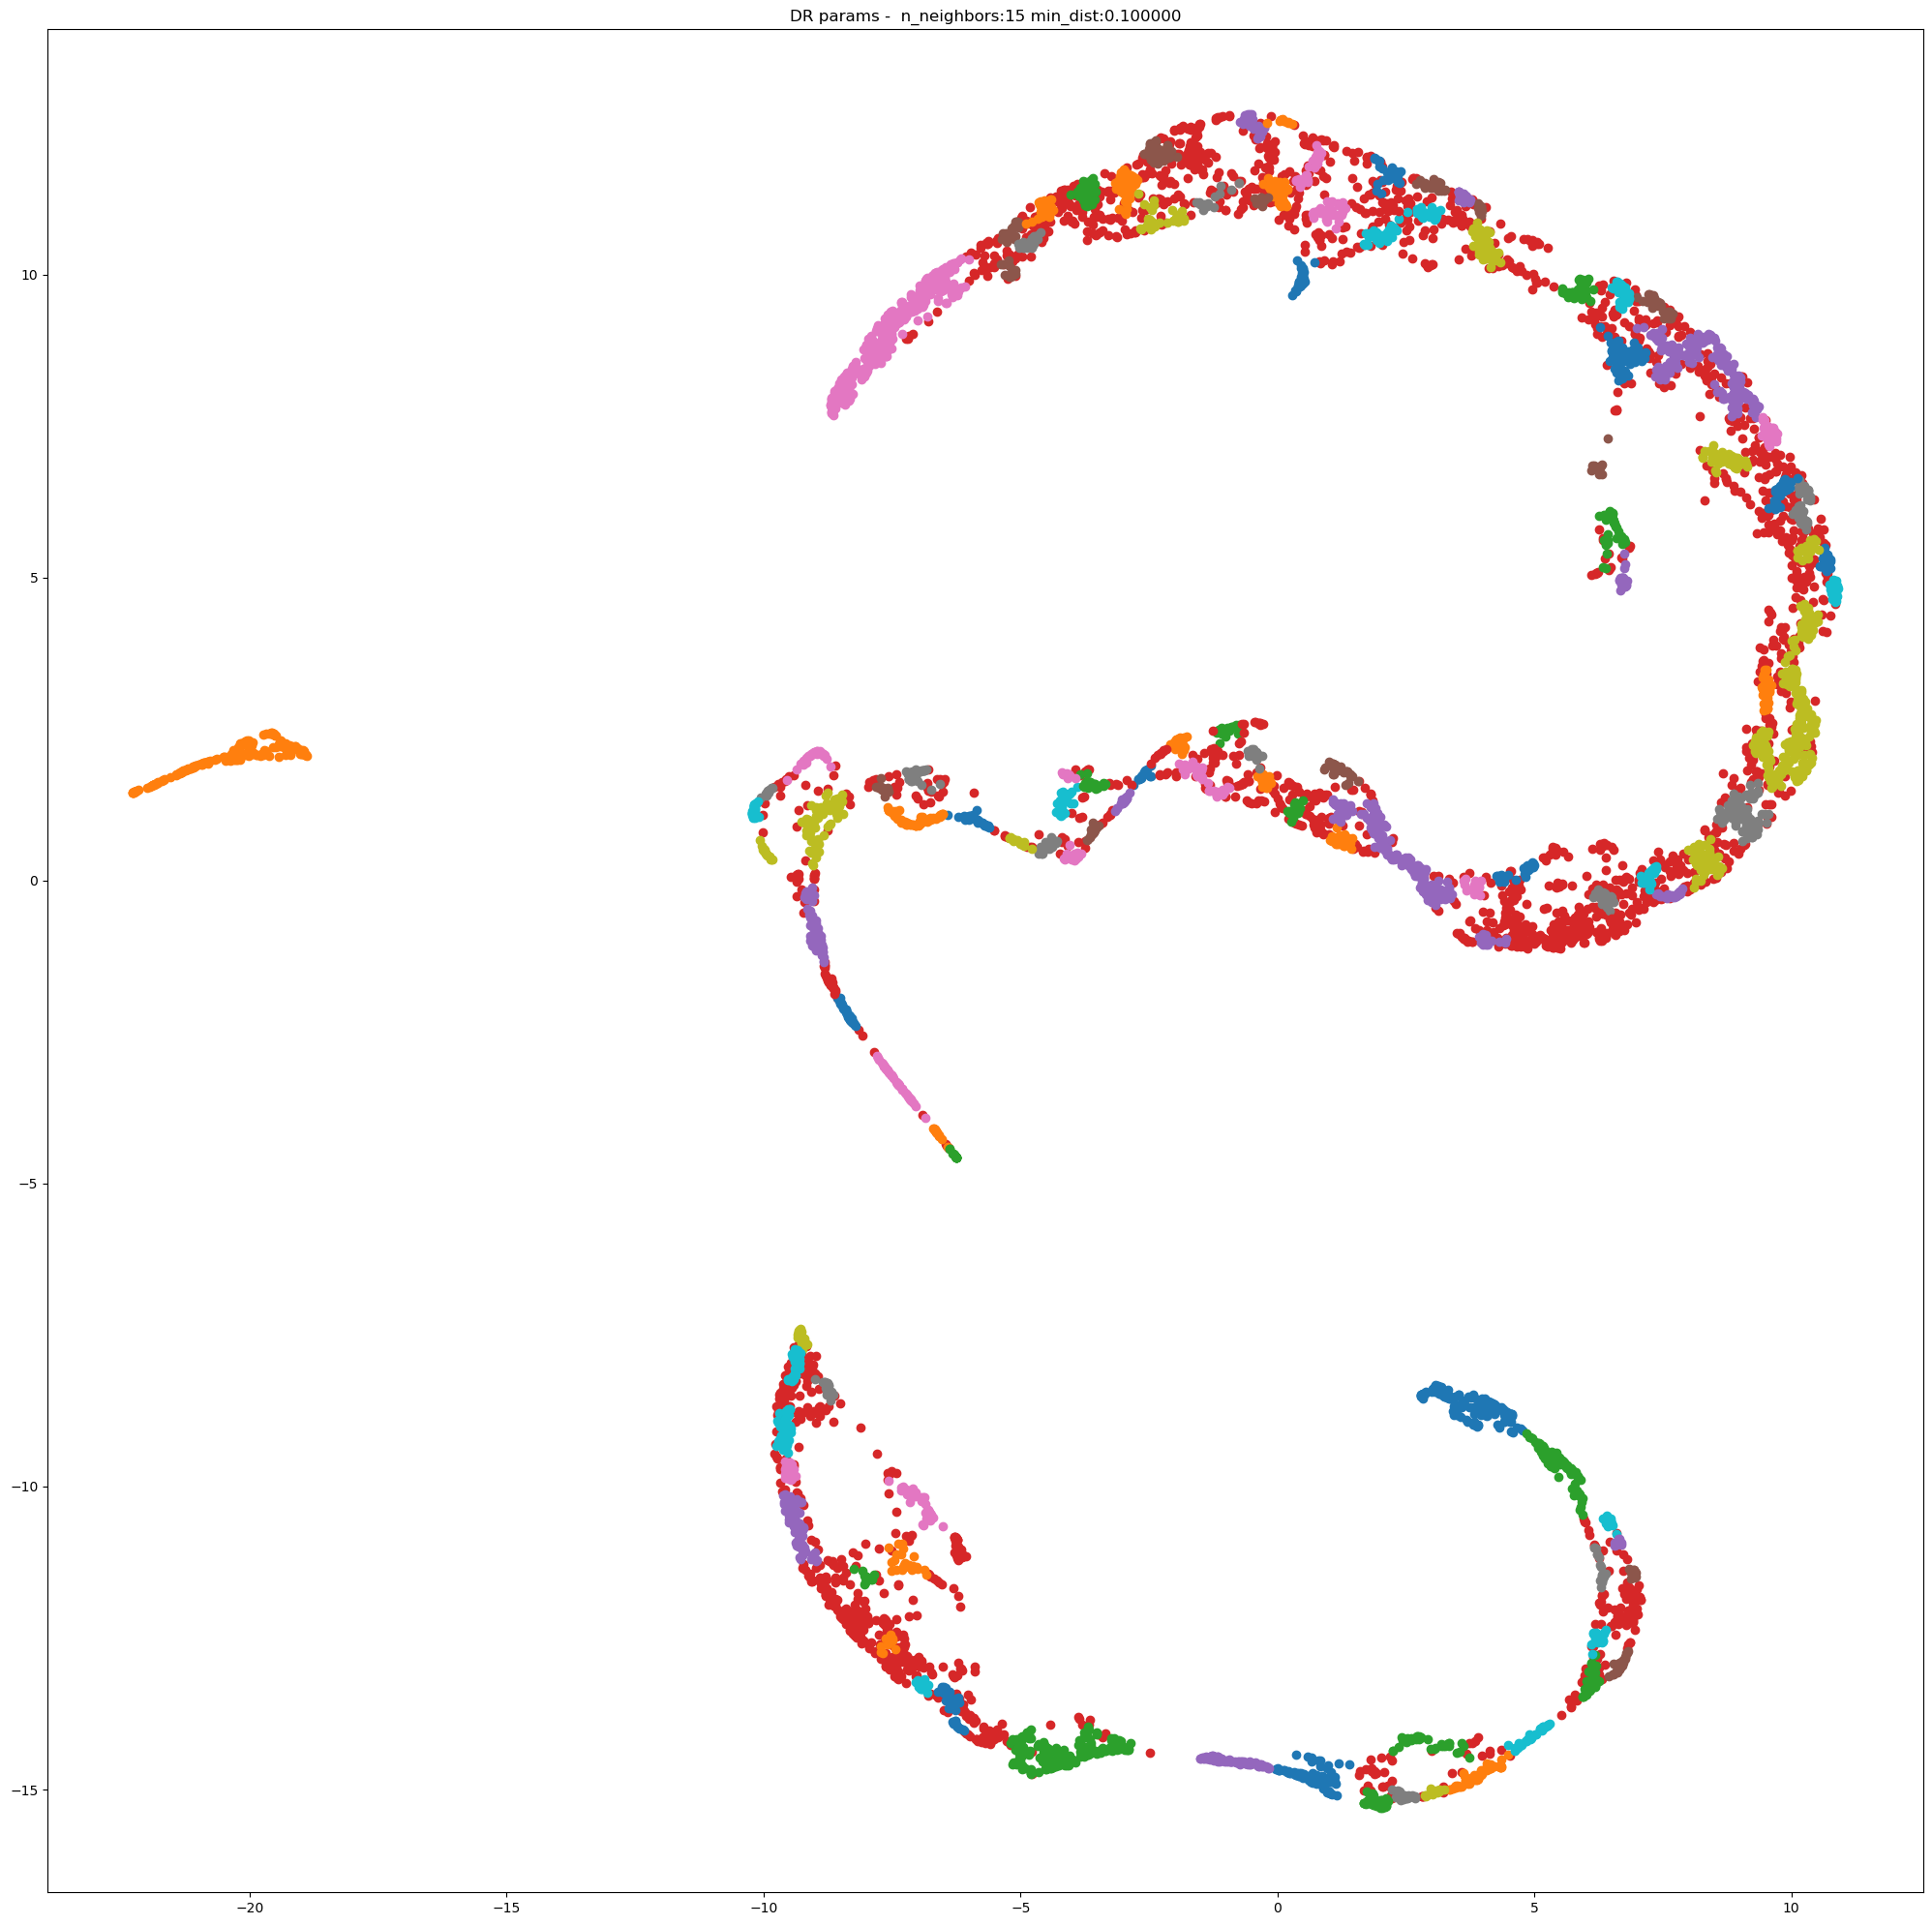

In [60]:
prjs_plt = plot_projections_clusters(prjs_umap, clusters_labels, umap_params)

In [61]:
beep(0.25)
beep(0.25)
beep(0.25)

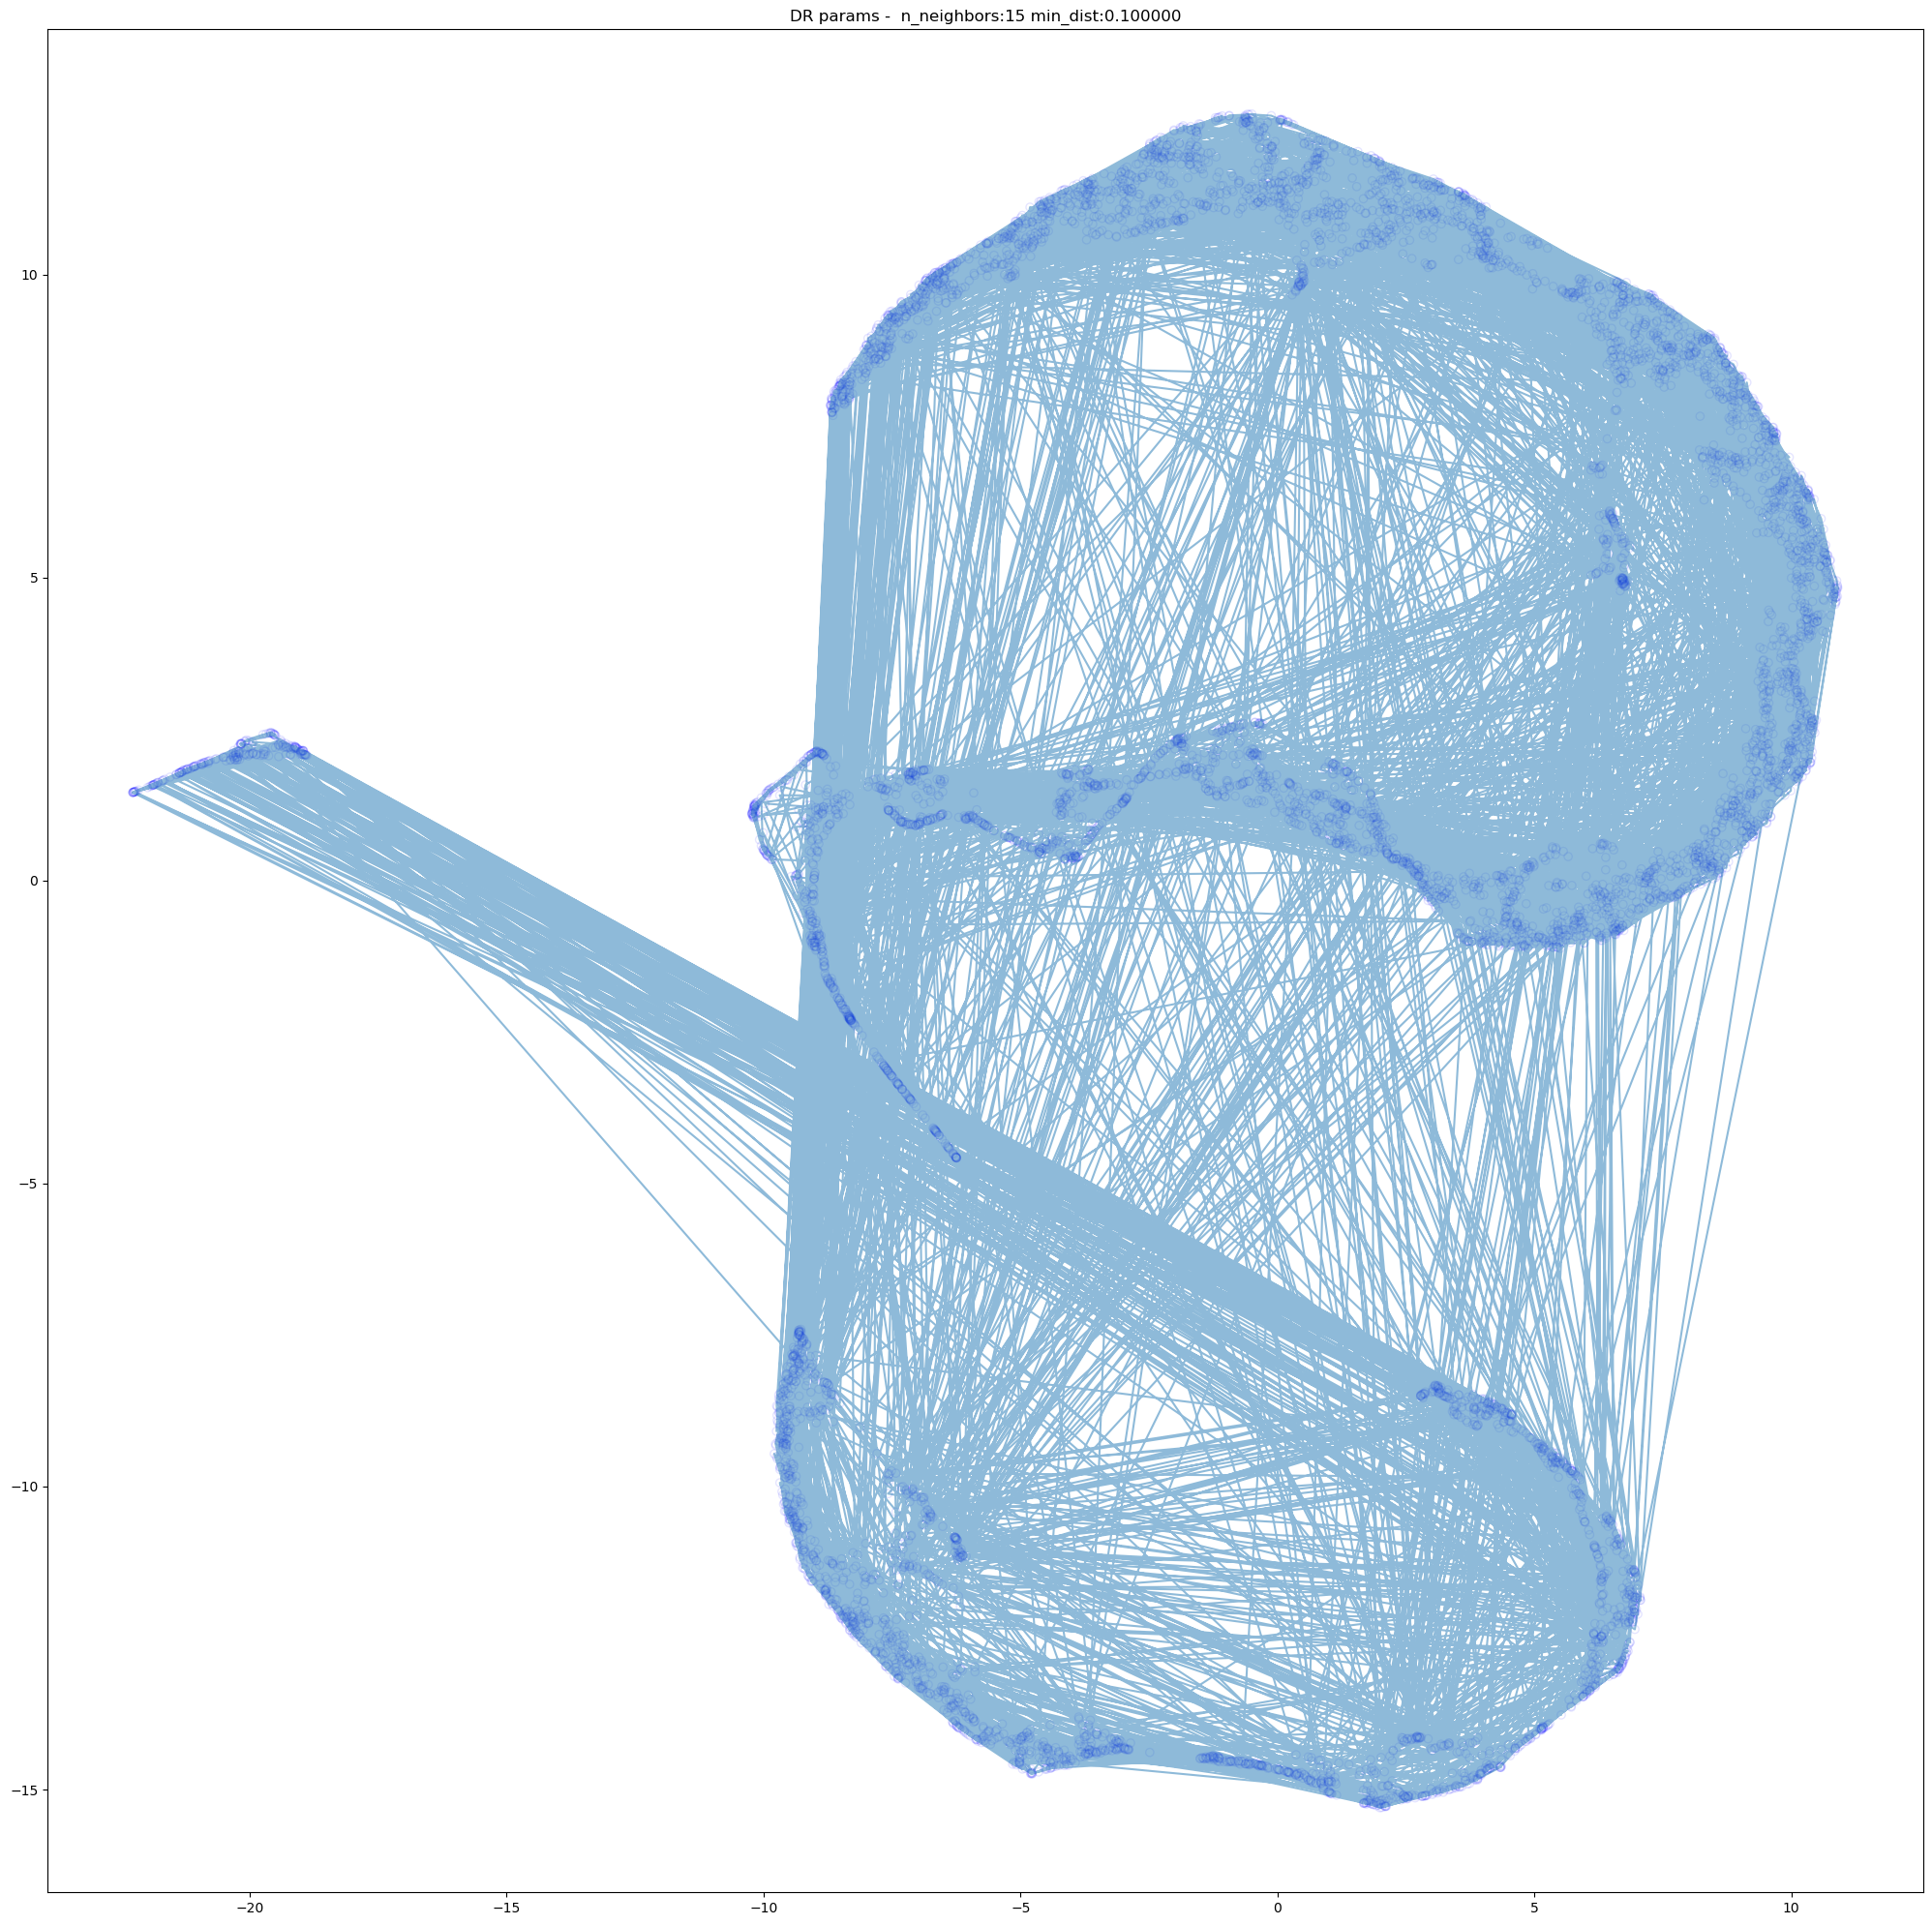

In [62]:
prjs_plt = plot_projections(prjs_umap, umap_params)

Log this plot as part of the current wandb run

In [63]:
#| hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [64]:
#| hide
run_dr.finish()

# Explainability with SHAP (future work)

In [65]:
# %matplotlib inline

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

# ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
# ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
# ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [66]:
# selected_indices = None
# selected_points = None

# def onpick(event):
#     global selected_points
#     thisline = event.artist
#     xdata = thisline.get_xdata()
#     ydata = thisline.get_ydata()
#     global selected_indices
#     selected_indices = event.ind
#     selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
#     print('onpick points (first):', selected_points[0])

# fig.canvas.mpl_connect('pick_event', onpick)

# plt.show()
# fig.tight_layout()
# fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [67]:
# selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
# selected_window

### Visualizing all the variables in the time window (default)

In [68]:
# %matplotlib inline
# g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
# g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [69]:
#export
# def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
#     "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
#     `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
#     x = dcae.get_layer(lat_ln).output
#     x = Dense(units=embeddings.shape[1], activation='linear')(x)
#     surrogate_model = Model(dcae.input, x)
#     l_nms = [layer.name for layer in surrogate_model.layers]
#     layer_idx = l_nms.index(lat_ln)
#     # The layers that are already trained from the autoencoder must be `frozen`
#     for layer in surrogate_model.layers[:layer_idx]:
#         layer.trainable = False
#     return surrogate_model

In [70]:
# sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [71]:
# test.equals(sm.input.shape, m.input.shape)
# test.equals(sm.output.shape[1], embeddings.shape[1])
# l_nms = [layer.name for layer in sm.layers]
# layer_idx = l_nms.index('latent_features')
# test.all_equal([layer.trainable for layer in sm.layers], \
#                np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [72]:
# loss = 'mean_squared_error'
# opt = 'adam'
# bs = 100
# epochs = 10
# val = .2

In [73]:
# sm.output_shape

In [74]:
# input_data.shape

In [75]:
# embeddings.shape

In [76]:
# sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [77]:
# import innvestigate

In [78]:
# analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [79]:
# asd= innvestigate.create_analyzer("gradient", m)

In [80]:
# from keras.datasets import mnist

In [81]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [82]:
# x_train.shape

In [83]:
# input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [84]:
# import shap

In [85]:
# background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(intermediate_model, background)

In [86]:
# shap_values = e.shap_values(input_data[0:4])

In [87]:
# shap_values[0][0]

In [88]:
print("Execution ended")
beep(1)

Execution ended


In [89]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)